In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.display import display
from IPython.html.widgets import *

Считаем прогнозы количества поездок в июне, подготовленные на прошлых неделях.

In [2]:
# данные прогнозов
fc = pd.read_csv('to_kaggle_w6.csv')
fc.histEndDay = pd.DatetimeIndex(fc.histEndDay)
fc['date_h'] = fc.histEndDay + [np.timedelta64(int(x), 'h') for x in fc.histEndHour.values]
fc.sort_values('geoID', inplace=True)

# расчитаем вспомогательные координаты для регионов
regs = pd.read_csv('regions.csv', sep = ';')
regs['avg_len'] = (regs.west + regs.east) / 2
regs['avg_lat'] = (regs.south + regs.north) / 2
regs['avg_lat_1'] = regs['avg_lat'] - 0.0015
regs['avg_lat_2'] = regs['avg_lat'] + 0.0015
regs.sort_values('region', inplace=True)

fc_1 = pd.DataFrame()
fc_1['geoID'] = np.unique(fc.geoID.values)
regs = pd.merge(regs, fc_1, how = 'right', left_on= 'region', right_on='geoID')

del fc_1

Считаем фактические метки.

In [3]:
real_d = pd.read_csv('fact_data_june.csv', parse_dates=['pickup_date_hour'])
real_d['date'] = pd.DatetimeIndex(real_d.pickup_date_hour).normalize()
real_d['hour'] = pd.DatetimeIndex(real_d.pickup_date_hour).hour
real_d.sort_values('region', inplace=True)

### Визуализируем прогнозы на карте

Создаем функцию, которая рисует карту NY и на ней отмечает при помощи тепловых карт фактическое и прогнозное количество поездок из каждого блока.

In [28]:
def heat_map_visualize(day=1, hour=1, step = 1):
    
    day = (pd.DatetimeIndex(['2016-06-01']) + np.timedelta64(1, 'D')).astype('str')[0]
    
    trips_log = fc.y[(fc.histEndDay == day)& (fc.histEndHour == hour)& (fc.step == step)].values
    real_dt = real_d['y_' + str(step)][(real_d.date == day)& (real_d.hour == hour)].values

    trips_log = [np.log10(x + 1) for x in trips_log]
    real_dt = [np.log10(x + 1) for x in real_dt]

    # координаты карты
    west, south, east, north = -74.25559, 40.49612, -73.70001, 40.91553
    #Создаем карту
    fig = plt.figure(figsize=(12,12))
    m = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
                llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='i')
    m.drawcoastlines(linewidth=1.5)

    # Наносим HeatMap прогноз
    m.scatter(regs.avg_len.values, regs.avg_lat_1.values,  latlon=True,
             c = trips_log, cmap='YlOrRd',  s = 20, marker = 's' )
    plt.colorbar(orientation = 'horizontal', pad = 0.02, aspect = 50)

    # Наносим HeatMap факт
    m.scatter(regs.avg_len.values, regs.avg_lat_2.values,  latlon=True,
             c = real_dt, cmap='BuPu',  s = 20, marker = 's' )
    plt.colorbar(orientation = 'vertical', pad = 0.02, aspect = 50)

    plt.show()

При помощи созданной функции и инструментов визуализации создадим интерактивный инструмент отображения прогнозов и фактических данных.

На карте каждая точка отмечана двумя тепловыми картами для каждой из точек. Интенсивность верхней части точки отражает фактическое количество поедок в момент времени. Нижняя часть - прогноз.

Перемещая слайдеры можно выбрать интересующий нас момент времени. Верхний слайдер - день месяца, средний - час, нижний - шаг прогнозирования.

(При работе со слайдерами обновление может занять некоторое время)

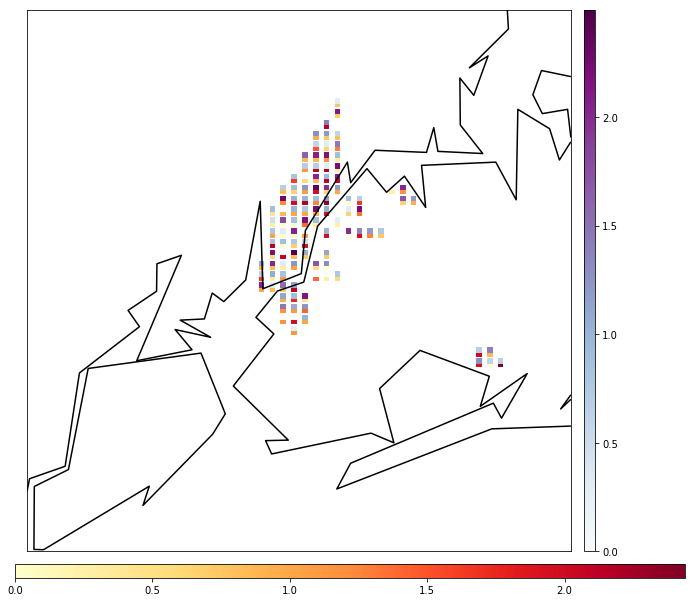

<function __main__.heat_map_visualize>

In [29]:
interact(heat_map_visualize, day = (0,31), hour= (0,23), step = (1,6))

### Визуализируем фактический и прогнозный для отдельных регионов на графиках.

Создадим функуцию, которая рисует график с 2-мя временными рядами - фактическим и прогнозным для выбранного региона

In [30]:
def print_line(region, step = 1):
    fc.sort_values('date_h', inplace=True)
    real_d.sort_values('pickup_date_hour', inplace= True)

    trips_reg = fc.y[(fc.geoID == region)& (fc.step == step)].values
    real_reg = real_d['y_' + str(step)][(real_d.region == region)].values
    time_m = real_d['pickup_date_hour'][(real_d.region == region)].values

    plt.figure(figsize = (20,7))
    plt.plot(time_m, real_reg, label = 'fact')
    plt.plot(time_m, trips_reg, 'r', label = 'forecast')
    plt.legend()
    plt.show()

Нанесем на график фактический и прогнозный временные ряды для каждого региона. При помощи интерактивного элемента - выпадающего списка можно выбрать номер интересующего нас региона и его графики будут отображены на экране.

Region № 1127


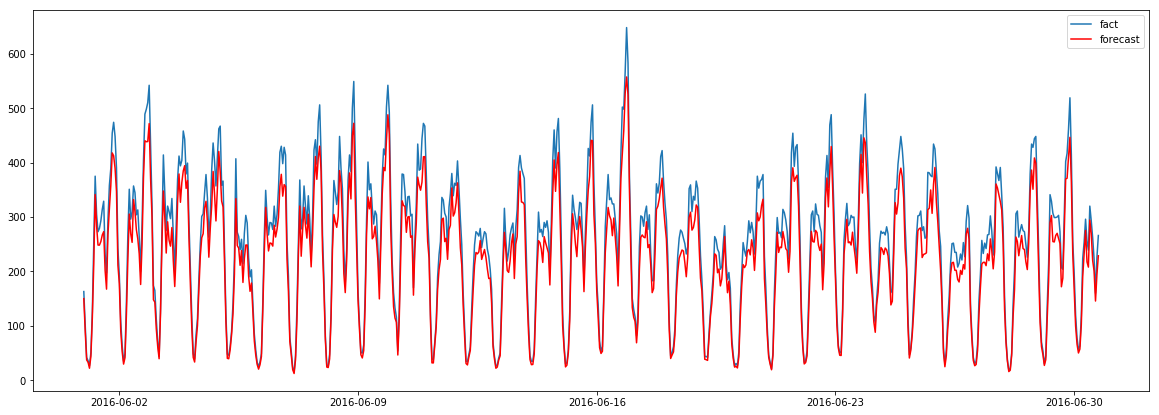

In [9]:
w = widgets.Dropdown(
    options=list(np.unique(real_d.region.values)),
    value=1075,
    description='Region:',
)


def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print('Region №', change['new'])
        print_line(change['new'])
        
w.observe(on_change)

display(w)